In [2]:
import logging
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt

import theano_shim as shim
import sinn
import sinn.histories as histories
from sinn.histories import Spiketrain, Series
import sinn.iotools as io
import sinn.analyze as anlz
from sinn.analyze.heatmap import HeatMap
import sinn.optimize.gradient_descent as gd

import main_1pop as main
import fsgif_model as fsgif

import copy


np.set_printoptions(precision=3, suppress=True)
%matplotlib inline

try:
    # Guard against defining multiple loggers
    logger
except NameError:
    rootlogger = logging.getLogger()
    rootlogger.setLevel(sinn.LoggingLevels.MONITOR)

    sthandler = logging.StreamHandler()
    sthandler.setLevel(logging.INFO)
    sthandler.setFormatter(sinn.config.logging_formatter)
    rootlogger.addHandler(sthandler)
    
    filehandler = logging.handlers.RotatingFileHandler(
        'fsgif.log', mode='w', maxBytes=5e5, backupCount=5)
    filehandler.setLevel(sinn.LoggingLevels.MONITOR)
    filehandler.setFormatter(sinn.config.logging_formatter)
    rootlogger.addHandler(filehandler)
    
    logger = logging.getLogger('fsgif')
    logger.setLevel(logging.INFO)

[monochrome_palette]: value was greater than 1 and was clipped.


In [3]:
import theano
import theano.tensor as T

In [4]:
source_datalen = 9 # Use 4 seconds of data
datalen = 8.5       # Amount of data to use for likelihood
burnin = 0.5        # Amount of data to discard from likelihood
mbatch_size = 100    # Batch size when computing likelihood / gradients

# Sample data trace

In [5]:
spikemodel = main.generate_spikes(datalen,
                                  filename='data/short_adap/spikes/fsgif_1pop_no-input_{}s_314seed'
                                           .format(source_datalen))

2017-07-27 13:34:33,462 - root - INFO - Checking for precomputed data...
2017-07-27 13:34:34,053 - root - INFO - Precomputed data found. Skipping data generation


In [6]:
main.compute_spike_activity(max_len=burnin+datalen)

(<sinn.histories.Series at 0x7fde18365c18>,
 <sinn.histories.Series at 0x7fde18365e10>)

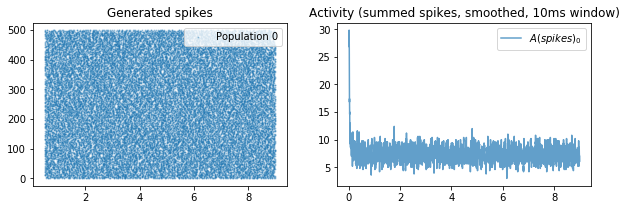

In [7]:
plt.figure(figsize=(10,3))

plt.subplot(1,2,1)
main.plot_raster(burnin, datalen)

plt.subplot(1,2,2)
main.plot_spike_activity()

In [8]:
sinn.inputs.clear()

main.load_theano()

In [9]:
main.loaded['spike activity']['Ahist'].unlock()
main.loaded['spike activity']['Ihist'].unlock()
main.loaded['spike activity']['Ahist'].theano_reset()
main.loaded['spike activity']['Ihist'].theano_reset()
main.loaded['spike activity']['Ahist'].lock()
main.loaded['spike activity']['Ihist'].lock()
try:
    mfmodelT.theano_reset()
    mfmodelT.clear_unlocked_histories()
except NameError:
    pass
mfmodelT = main.derive_mf_model_from_spikes()

2017-07-27 13:34:35,253 - root - INFO - Producing Theano mean-field model.
2017-07-27 13:34:37,167 - root - INFO - Theano model complete.


In [10]:
mfmodelT.theano_reset()
mfmodelT.clear_unlocked_histories()

2017-07-27 13:34:48,621 - theano_shim - INFO - Clearing Theano updates


# Fits (gradient descent)

In [11]:
basedir = "data/short_adap/fits/random_init/"

In [12]:
import os
import zipfile

In [13]:
Key = namedtuple('Key', ('seed', 'batch', 'lr', 'params', 'suffix'))
#def make_key(desc_tuple):
#    if len(desc_tuple) == 3:
#        desc_tuple += (None,)
#    assert(len(desc_tuple) == 4)
#    return Key(*desc_tuple)

In [14]:
sgds_initrnd = {}
for fname in os.listdir(basedir):
    if fname[:3] != "fit":
        continue

    keydict = {keyname: None for keyname in Key._fields}
    for keyname in keydict:
        stopidx = fname.find(keyname)
        if stopidx == -1:
            keydict[keyname] = None
        else:
            startidx = fname.rfind('_', 0, stopidx)
            keyval = fname[startidx+1:stopidx]
            if '-' in keyval:
                keydict[keyname] = float(keyval.replace('-', '.'))
            else:
                keydict[keyname] = int(keyval)
    # 'suffix' key
    if 'suffix' in keydict:
        extpos = fname.rfind('.')
        if fname[extpos-1] in '1234567890':
            suffixpos = fname.rfind('_', 0, extpos) + 1
            keydict['suffix'] = int(fname[suffixpos:extpos])
    key = Key(**keydict)
    try:
        sgds_initrnd[key] = gd.SGD(mfmodelT.loglikelihood, mfmodelT, 'adam',
                                   sgd_file = basedir + fname)
    except zipfile.BadZipFile:
        logger.warning("Unable to load file '{}'; it may be corrupted."
                       .format(basedir + fname))


In [15]:
for key, sgd in sgds_initrnd.items():
    if key.lr == 0.0005:
        sgd.verify_transforms(trust_automatically=True)

In [33]:
keytuples_initgt = [(0, 100, 0.005),  (100, 100, 0.005),  (200, 100, 0.005),  (300, 100, 0.005),
                    (0, 100, 0.0005), (100, 100, 0.0005), (200, 100, 0.0005), (300, 100, 0.0005),
                    (0, 500, 0.005),  (100, 500, 0.005),  (200, 500, 0.005),  (300, 500, 0.005)]
keys_initgt = [make_key(t) for t in keytuples_initgt]

In [34]:
keytuples_initrnd = [(0, 100, 0.0005, None)] + [(0, 100, 0.0005, i) for i in range(2,13)]
keys_initrnd = [make_key(t) for t in keytuples_initrnd]

In [31]:
sgds_initgt = {key: gd.SGD(mfmodelT.loglikelihood, mfmodelT, 'adam', 
                           sgd_file = basedir + "fit_8s_{}lr_{:0>3}batch_{:0>3}seed.sir"
                                               .format(str(key.lr)[2:], key.batch, key.seed))
        for key in keys_initgt}

In [14]:
basedir = "data/short_adap/fits/random_init/"

In [47]:
filenames = []
for key in keys_initrnd:
    suffix = "" if key.repeat is None else "_" + str(key.repeat)
    filenames.append(basedir + "fit_8s_{}lr_{:0>3}batch_{:0>3}seed{}.sir"
                               .format(str(key.lr)[2:], key.batch, key.seed, suffix))

sgds_initrnd = {key: gd.SGD(mfmodelT.loglikelihood, mfmodelT, 'adam', sgd_file = filename)
                for key, filename in zip(keys_initrnd, filenames)}

In [40]:
def plot_evol2(sgds, lr, batch):
    plt.figure(figsize=(13, 3))
    
    plt.subplot(1,3,1)
    plt.title('$w_{EE}$ evolution')
    for key, sgd in sgds.items():
        if key.lr == lr and key.batch == batch:
            plt.plot(sgd.get_evol()['w'][:,0,0])
    plt.xlabel("epoch")
    plt.ylabel("$w_{EE}$")
    plt.axhline(0.176, color='orange')
    
    plt.subplot(1,3,2)
    plt.title('$τ_{m,I}$ evolution')
    for key, sgd in sgds.items():
        if key.lr == lr and key.batch == batch:
            plt.plot(10**(sgd.get_evol()['logτ_m'][:,1]))
    plt.xlabel('epoch')
    plt.ylabel('$τ_{m,I}$')
    plt.axhline(0.02, color='orange')
    
    plt.subplot(1,3,3)
    plt.title("log L evolution")
    for key, sgd in sgds.items():
        if key.lr == lr and key.batch == batch:
            plt.plot(sgd.get_evol()['logL'])
    plt.xlabel("epoch")
    plt.ylabel("log L")

In [17]:
sgd = list(sgds_initrnd.values())[0]

In [19]:
for i in range(5):
    pass
print(i)

4


In [52]:
param_list = ['w', 'logτ_m', 'c', 'u_rest', 'τ_s', 'u_th', 'u_r', 'Δu']

def plot_evol2(sgds, lr, batch, nparams):
    
    ncols = 2
    nrows = int(np.ceil(nparams / 2))+1
    
    plt.figure(figsize=(13, 4*nrows))
    
    for i, pname in enumerate(param_list[:nparams]):
        plt.subplot(nrows, ncols, i+1)
        plt.title('${}$ evolution'.format(pname))
        for key, sgd in sgds.items():
            if key.lr == lr and key.batch == batch and key.params == nparams:
                plt.plot(sgd.get_evol()[pname].flat)
        plt.ylabel('${}$'.format(pname))
        for p in mfmodelT.params:
            if p.name == pname:
                plt.axhline(sgd.trueparams[p].flat[0], color='red')
                break
    
    plt.subplot(nrows,ncols, nrows * ncols - (ncols -1))
    plt.title("log L evolution")
    for key, sgd in sgds.items():
        if key.lr == lr and key.batch == batch:
            plt.plot(sgd.get_evol()['logL'])
    plt.xlabel("epoch")
    plt.ylabel("log L")

In [53]:
param_list = ['w', 'logτ_m', 'c', 'u_rest', 'τ_s', 'u_th', 'u_r', 'Δu']

def plot_evol(sgds, lr, batch, nparams):
    
    pname = param_list[nparams-1]
    plt.title('${}$ evolution'.format(pname))
    for key, sgd in sgds.items():
        if key.lr == lr and key.batch == batch and key.params == nparams:
            plt.plot(sgd.get_evol()[pname].flat)
    plt.ylabel('${}$'.format(pname))
    
    for p in mfmodelT.params:
        if p.name == pname:
            plt.axhline(sgd.trueparams[p].flat[0], color='red')
            break

In [17]:
for key, sgd in sgds_initrnd.items():
    print(key, "  ---  ", sgd.param_evol[mfmodelT.params.w][-1][0,0])

Key(seed=314, batch=100, lr=0.005, params=3, suffix=4)   ---   0.248931656379
Key(seed=314, batch=100, lr=0.005, params=5, suffix=2)   ---   -0.61175641365
Key(seed=314, batch=100, lr=0.005, params=6, suffix=6)   ---   nan
Key(seed=314, batch=100, lr=0.005, params=8, suffix=5)   ---   6.1582594192
Key(seed=314, batch=100, lr=0.005, params=2, suffix=7)   ---   5.38119471045
Key(seed=314, batch=100, lr=0.005, params=None, suffix=2)   ---   0.247506229552
Key(seed=314, batch=100, lr=0.005, params=5, suffix=3)   ---   6.1582594192
Key(seed=314, batch=100, lr=0.005, params=1, suffix=4)   ---   -0.0562668272263
Key(seed=314, batch=100, lr=0.005, params=8, suffix=8)   ---   nan
Key(seed=314, batch=100, lr=0.005, params=8, suffix=6)   ---   -0.61175641365
Key(seed=314, batch=100, lr=0.005, params=4, suffix=8)   ---   -0.0562668272263
Key(seed=314, batch=100, lr=0.005, params=7, suffix=8)   ---   0.248931656379
Key(seed=314, batch=100, lr=0.005, params=3, suffix=6)   ---   -0.0562668272263
Key(

In [16]:
badsgd, goodsgd = list(sgds_initrnd.values())[0], list(sgds_initrnd.values())[2]

In [17]:
print(badsgd.param_evol[mfmodelT.params.w][-1][0,0])
print(goodsgd.param_evol[mfmodelT.params.w][-1][0,0])

21.7470762779
0.210739421766


In [19]:
mfmodelT.params.w.get_value()

array([[ 0.176, -0.702],
       [ 0.176, -0.702]])

In [21]:
goodsgd.compile(main.get_fitmask(mfmodelT))

2017-07-26 23:34:52,441 - sinn.optimize.gradient_descent - WARNING - Replacing 'fitparams'. Previous fitparams are lost.
2017-07-26 23:34:52,442 - theano_shim - INFO - Clearing Theano updates
2017-07-26 23:34:52,445 - sinn.optimize.gradient_descent - INFO - Producing the cost function theano graph
2017-07-26 23:34:52,446 - fsgif_model - INFO - Producing the likelihood graph.
2017-07-26 23:34:52,656 - fsgif_model - INFO - Likelihood graph complete
2017-07-26 23:34:52,658 - sinn.optimize.gradient_descent - INFO - Cost function graph complete.
2017-07-26 23:34:52,658 - sinn.optimize.gradient_descent - INFO - Performing variable substitutions in Theano graph.
2017-07-26 23:34:52,668 - sinn.optimize.gradient_descent - INFO - Substitutions complete.
2017-07-26 23:34:52,669 - sinn.optimize.gradient_descent - INFO - Compiling the minibatch cost function.
2017-07-26 23:34:54,663 - sinn.optimize.gradient_descent - INFO - Done compilation.
2017-07-26 23:34:54,664 - sinn.optimize.gradient_descent 

In [20]:
badsgd.compile(main.get_fitmask(mfmodelT))

2017-07-27 01:59:10,658 - sinn.optimize.gradient_descent - WARNING - Replacing 'fitparams'. Previous fitparams are lost.
2017-07-27 01:59:10,659 - theano_shim - INFO - Clearing Theano updates
2017-07-27 01:59:10,663 - sinn.optimize.gradient_descent - INFO - Producing the cost function theano graph
2017-07-27 01:59:10,664 - fsgif_model - INFO - Producing the likelihood graph.
2017-07-27 01:59:10,922 - fsgif_model - INFO - Likelihood graph complete
2017-07-27 01:59:10,923 - sinn.optimize.gradient_descent - INFO - Cost function graph complete.
2017-07-27 01:59:10,924 - sinn.optimize.gradient_descent - INFO - Performing variable substitutions in Theano graph.
2017-07-27 01:59:10,934 - sinn.optimize.gradient_descent - INFO - Substitutions complete.
2017-07-27 01:59:10,934 - sinn.optimize.gradient_descent - INFO - Compiling the minibatch cost function.
2017-07-27 01:59:12,907 - sinn.optimize.gradient_descent - INFO - Done compilation.
2017-07-27 01:59:12,908 - sinn.optimize.gradient_descent 

In [21]:
badsgd.set_params_to_evols()

In [44]:
badsgd.iterate(1000, lr=0.1)

2017-07-27 02:15:34,977 - sinn.optimize.gradient_descent - INFO - Iteration 62103 – <log L> = -2856.10
2017-07-27 02:15:34,978 - sinn.optimize.gradient_descent - INFO - Cost/likelihood evaluation : 2583.4s / 118.6s (2178.3% total execution time)
2017-07-27 02:15:34,978 - sinn.optimize.gradient_descent - INFO - Time per iteration: 1.910ms


Did not converge.


In [45]:
mfmodelT.params.w.get_value()

array([[ 21.551,  -0.702],
       [  0.176,  -0.702]])

In [35]:
mfmodelT.params.w.get_value()

array([[ 21.747,  -0.702],
       [  0.176,  -0.702]])

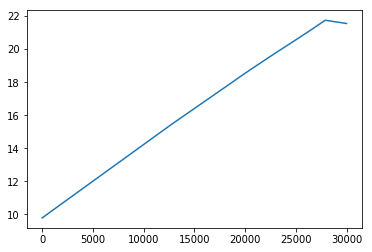

In [57]:
plt.plot(badsgd.get_evol()[wparam][-30000:][:,0,0])

In [52]:
tauparam in badsgd.param_evol.keys()

False

In [47]:
tauparam = list(badsgd.get_evol().keys())[0]
wparam = list(badsgd.get_evol().keys())[1]

In [69]:
mfmodelT.params.w.get_value()[0]

array([ 0.2  , -0.702])

In [72]:
badsgd.param_evol

{logτ_m: deque([array([-1.69897, -1.69897])]),
 c: deque([array([ 10.,  10.])]),
 w: deque([array([[ 0.19982045, -0.702     ],
               [ 0.176     , -0.702     ]])])}

In [45]:
list(goodsgd.param_evol.keys())[0].get_value()

array([-1.699, -1.674])

In [55]:
mfmodelT.params.w is list(badsgd.param_evol.keys())[2]

True

In [60]:
for param, evol in badsgd.param_evol.items():
    print(param.name)
    print(param is mfmodelT.params.w)
    print(param.get_value())
    param.set_value(evol[-1])
    print(mfmodelT.params.w.get_value())
    print("----------")

logτ_m
False
[-1.699 -1.699]
[[ 0.2   -0.702]
 [ 0.176 -0.702]]
----------
c
False
[ 10.  10.]
[[ 0.2   -0.702]
 [ 0.176 -0.702]]
----------
w
True
[[ 0.2   -0.702]
 [ 0.176 -0.702]]
[[ 0.2   -0.702]
 [ 0.176 -0.702]]
----------


In [56]:
badsgd.param_evol

{logτ_m: deque([array([-1.699, -1.699])]),
 c: deque([array([ 10.,  10.])]),
 w: deque([array([[ 0.2  , -0.702],
               [ 0.176, -0.702]])])}

In [21]:
logL = HeatMap.from_raw(io.loadraw("data/short_adap/likelihoods/fsgif_no-input_8s_314seed_loglikelihood_theano.sir"))
logL.set_floor(logL.max()-100)

# 1 population

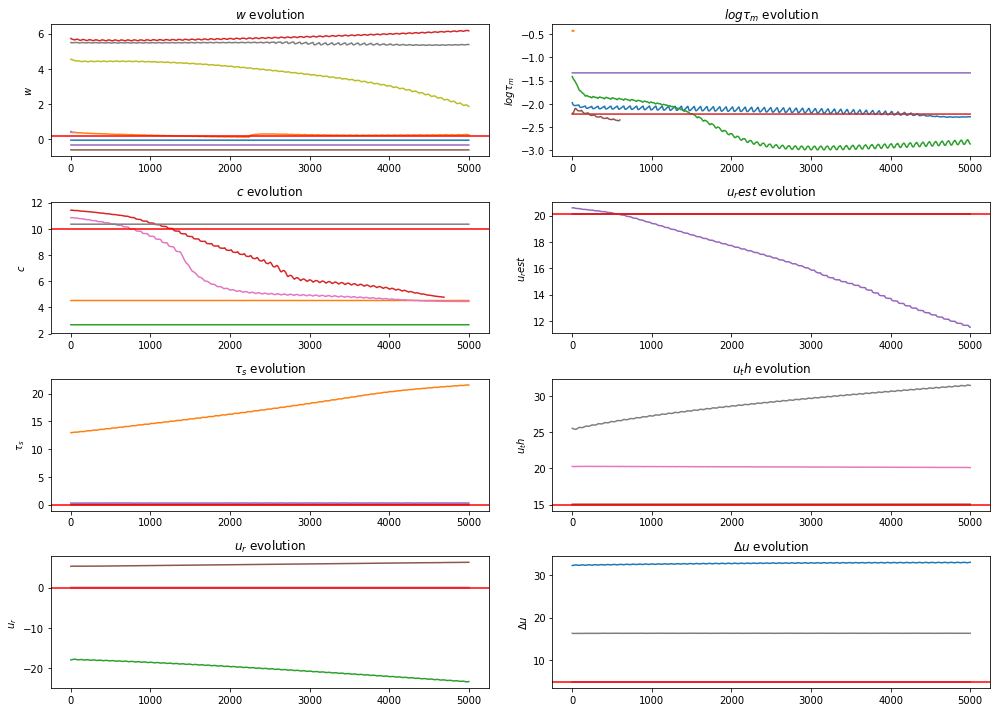

In [56]:
plt.figure(figsize=(14, 10))
for n in range(8):
    plt.subplot(4, 2, n+1)
    plot_evol(sgds_initrnd, 0.005, 100, n+1)
    plt.tight_layout()

In [51]:
%debug

> <ipython-input-45-1360c47c1e9b>(9)plot_evol()
      7     for key, sgd in sgds.items():
      8         if key.lr == lr and key.batch == batch and key.params == nparams:
----> 9             plt.plot(sgd.get_evol()[pname].flat)
     10     plt.ylabel('${}$'.format(pname))
     11 

ipdb> sgd.get_evol().keys()
dict_keys(['u_rest', 'Δu', 'logτ_m', 'w', 'u_th', 'logL', 'τ_s', 'c', 'u_r'])
ipdb> exit


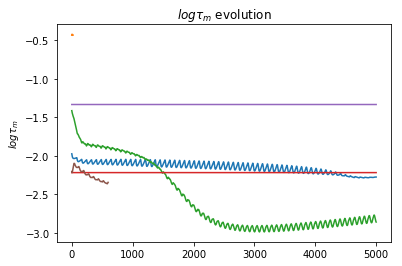

In [46]:
n = 2
plot_evol(sgds_initrnd, 0.005, 100, 2)

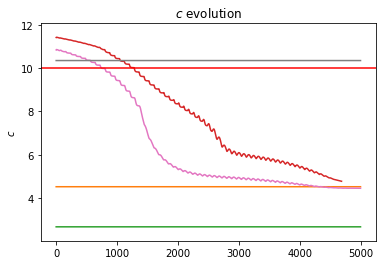

In [48]:
plot_evol(sgds_initrnd, 0.005, 100, 3)

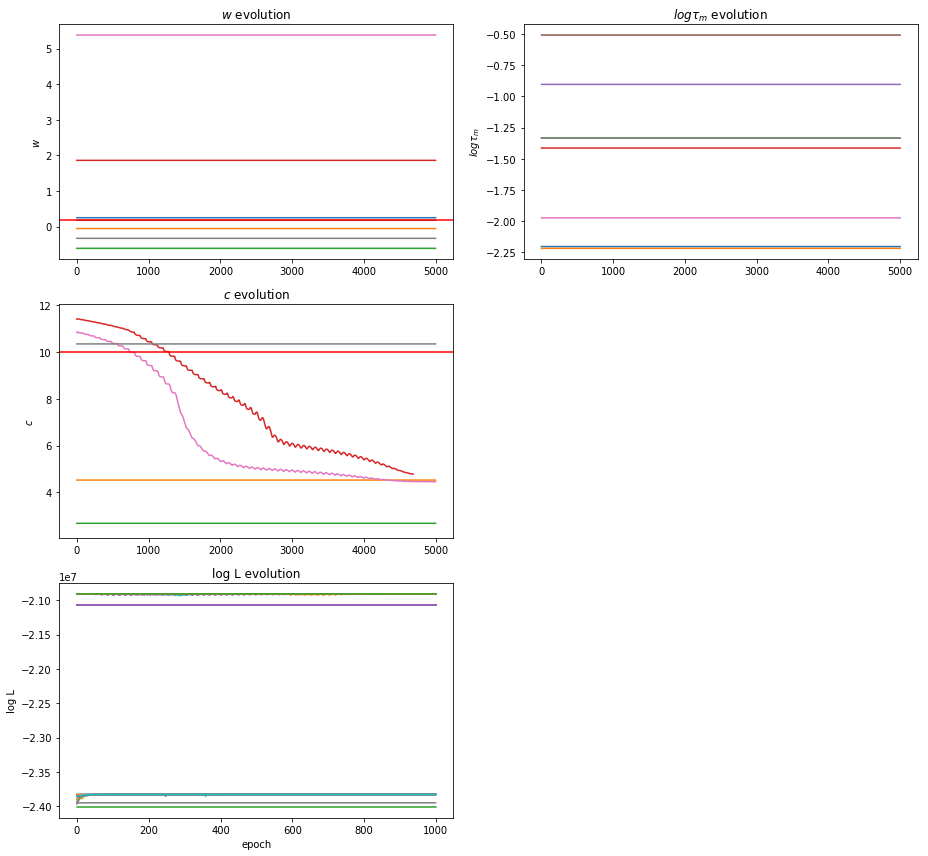

In [34]:
n = 3
plt.suptitle("{} parameter fit".format(n))
plot_evol(sgds_initrnd, 0.005, 100, n)
plt.tight_layout()

## learning rate: 0.005, batch size: 100

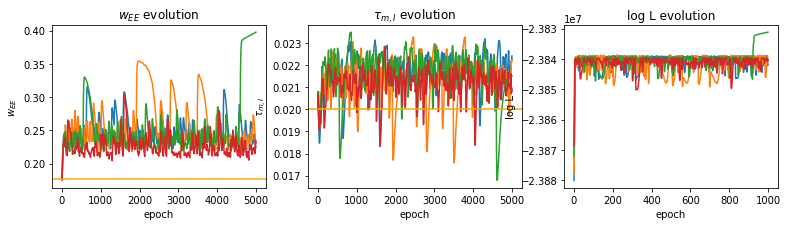

In [39]:
plot_evol(0.005, 100)

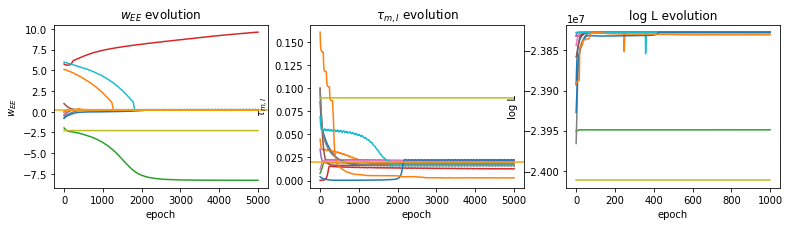

In [17]:
plot_evol(sgds_initrnd, 0.005, 100)

In [26]:
for key, sgd in sgds_initrnd.items():
    if key.lr == 0.005 and key.batch == 100:
        sgd.verify_transforms()

(0, 1)

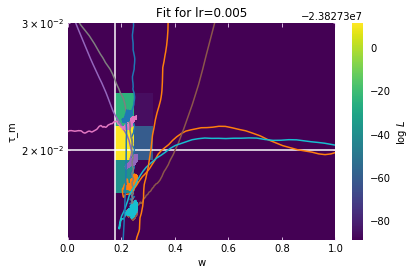

In [27]:
plt.title("Fit for lr=0.005")

anlz.plot(logL)
for key, sgd in sgds_initrnd.items():
    if key.lr == 0.005 and key.batch == 100:
        sgd.plot_param_evol_overlay(logL)
plt.axvline(sgd.trueparams[mfmodelT.params.w][0,0], color='white', zorder=1)
plt.axhline(sgd.trueparams[mfmodelT.params.τ_m][1], color='white', zorder=1)

plt.ylim((0.015, 0.03))
plt.xlim((0, 1))

## learning rate: 0.0005, batch size: 100

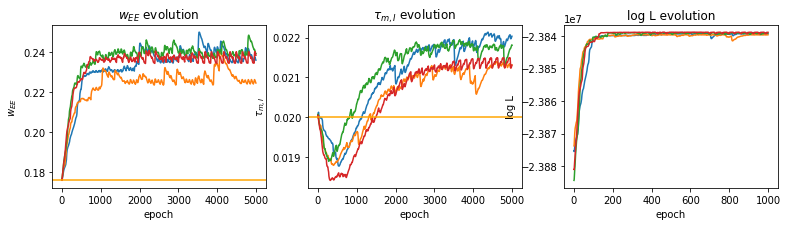

In [20]:
plot_evol(0.0005, 100)

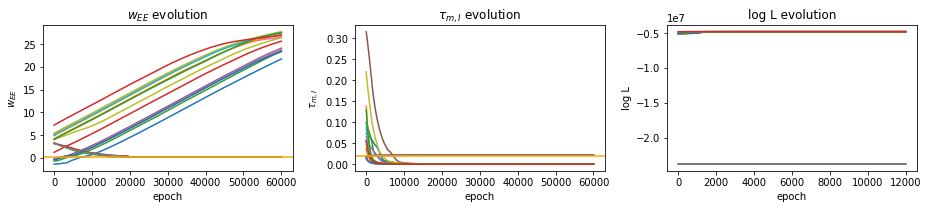

In [16]:
plot_evol(sgds_initrnd, 0.0005, 100)
plt.tight_layout()

In [22]:
sgd = list(sgds_initrnd.values())[0]

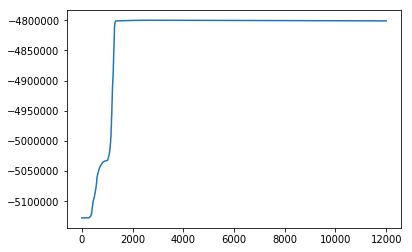

In [25]:
plt.plot(sgd.get_evol()['logL'])

In [19]:
for key, sgd in sgds_initrnd.items():
    if key.lr == 0.0005:
        sgd.verify_transforms(trust_automatically=True)

(-2, 6)

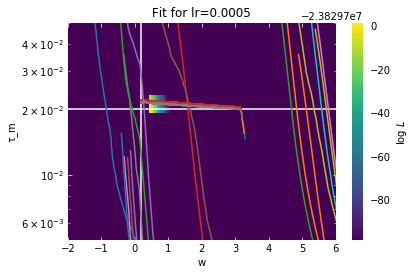

In [28]:
plt.title("Fit for lr=0.0005")

anlz.plot(logL)
plt.axvline(sgd.trueparams[mfmodelT.params.w][0,0], color='white', zorder=1)
plt.axhline(sgd.trueparams[mfmodelT.params.τ_m][1], color='white', zorder=1)

#logL.set_ceil(logL[0.0:0.3, 0.015:0.03].max())
#logL.set_floor(logL[0.0:0.3, 0.015:0.03].min())

#for key, sgd in sgds_initgt.items():
#    if key.lr == 0.0005:
#        sgd.plot_param_evol_overlay(logL)
        
for key, sgd in sgds_initrnd.items():
    if key.lr == 0.0005:
        sgd.plot_param_evol_overlay(logL)

plt.gca().set_facecolor('#440154')
#plt.ylim((0.015, 0.03))
#plt.xlim((0, 1))
plt.ylim((0.005, 0.05))
plt.xlim((-2, 6))

(0, 1)

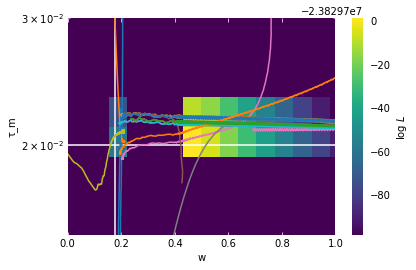

In [24]:
anlz.plot(logL)
plt.axvline(sgd.trueparams[mfmodelT.params.w][0,0], color='white', zorder=1)
plt.axhline(sgd.trueparams[mfmodelT.params.τ_m][1], color='white', zorder=1)

for key, sgd in sgds_initrnd.items():
    if key.lr == 0.0005:
        sgd.plot_param_evol_overlay(logL)

plt.ylim((0.015, 0.03))
plt.xlim((0, 1))

(0, 0.3)

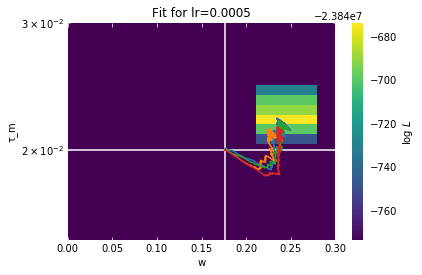

In [26]:
plt.title("Fit for lr=0.0005")

anlz.plot(logL)
for key, sgd in sgds.items():
    if key.lr == 0.0005:
        sgd.plot_param_evol_overlay(logL)
plt.axvline(sgd.trueparams[mfmodelT.params.w][0,0], color='white', zorder=1)
plt.axhline(sgd.trueparams[mfmodelT.params.τ_m][1], color='white', zorder=1)

logL.set_ceil(logL[0.0:0.3, 0.015:0.03].max())
logL.set_floor(logL[0.0:0.3, 0.015:0.03].min())

plt.ylim((0.015, 0.03))
plt.xlim((0, 0.3))

(<matplotlib.axes._subplots.AxesSubplot at 0x7f3464554518>,
 <matplotlib.colorbar.Colorbar at 0x7f34644fb6a0>)

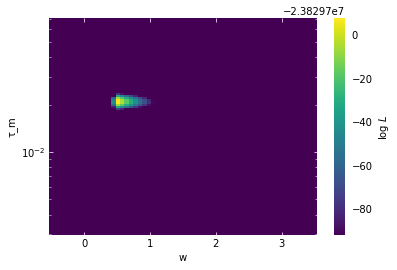

In [18]:
anlz.plot(logL)

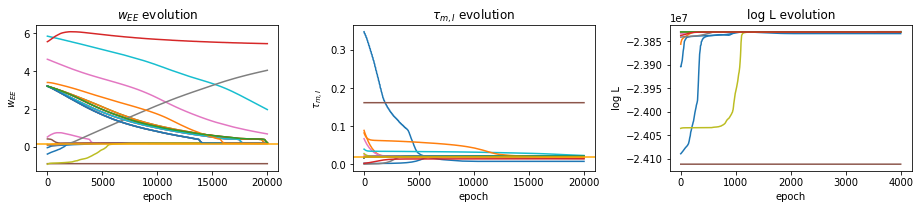

In [24]:
plot_evol(sgds_initrnd, lr=0.0005, batch=100)
plt.tight_layout()

In [28]:
sgd = list(sgds_initrnd.values())[0]

In [36]:
sgd.get_evol()['w']

array([[[-0.033, -0.702],
        [ 0.176, -0.702]],

       [[-0.033, -0.702],
        [ 0.176, -0.702]],

       [[-0.034, -0.702],
        [ 0.176, -0.702]],

       ..., 
       [[ 0.201, -0.702],
        [ 0.176, -0.702]],

       [[ 0.201, -0.702],
        [ 0.176, -0.702]],

       [[ 0.201, -0.702],
        [ 0.176, -0.702]]])

## learning rate: 0.005, batch size: 500

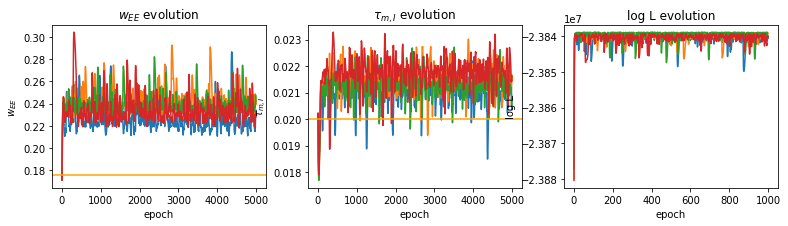

In [42]:
plot_evol(0.005, 500)